# GRU을 이용한 텍스트 생성
 - 데이터 다운로드 : 캐글 New York Times Comments
 - ArticalesApril2018.csv

In [ ]:
from google.colab import files
up = files.upload()

In [1]:
import pandas as pd
df = pd.read_csv('ArticlesApril2018.csv', encoding='latin1')
# df = pd.read_csv('/content/ArticlesApril2018.csv', encoding='latin1')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleadersâ Settlement Offer...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"âI understand that they could meet with us, ...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,Whatâs it like to eat at the second incarnat...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Torontoâs ...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


## 데이터 전처리
     - 헤드라인을 가지고 학습을 시켜서. 문장을 제대로 재생을 하는지 확인해 보자

In [2]:
# 1. Null이 있는지 확인 # 널값은 없어. 
df.headline.isnull().sum()

0

In [3]:
# headline 컬럼 스트링이 있는 리스트로 만들어 학습
# headline 컬럼 : 시리즈 타입 ----> 리스트 
# 다만 이렇게 되면 언노운을 지울 수 없어
# headlines = df.headline.values.tolist()
# headlines[:5]

['Former N.F.L. Cheerleadersâ\x80\x99 Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [4]:
len(headlines)

1324

In [5]:
# 노이즈 데이터 ('Unknown') 제거
headlines = [line for line in df.headline.values if line != 'Unknown']
# headlines[:5]
len(headlines)

1214

In [6]:
# encoding, 구둣점 제거, 소문자로 변환 => preprocessing
import re
def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^A-Za-z0-9 ]', '', s)   # re.sub（정규 표현식,  , 치환 문자 대상 문자열）
    return s.lower()

In [7]:
headlines = [preprocessing(line) for line in headlines]
headlines[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

## Keras 텍스트 전처리

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [9]:
# 단어 집합 생성
t = Tokenizer()
t.fit_on_texts(headlines)

In [10]:
# 단어 집합 크기 - keras Tokenizer의 시작 인덱스가 1이기 때문
vocab_size = len(t.word_index) + 1
vocab_size

3494

In [11]:
sequences = []
for line in headlines:
    encoded=t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

In [12]:
max_len = max(len(seq) for seq in sequences)
max_len

24

In [13]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
sequences[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          99,  269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   99,
         269,  371],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   99,  269,
         371, 1115]], dtype=int32)

In [14]:
X = sequences[:,:-1]
y = sequences[:,-1]
Y = to_categorical(y)
X.shape, Y.shape

((7803, 23), (7803, 3494))

## 모델 정의 설정 학습
 - Embedding: 10 차원
 - LSTM: 128 units

In [15]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense

In [17]:
# 임베딩 벡터 10차원, GRU 노드 크기 128
model = Sequential([ 
    Embedding(vocab_size, 10, input_length=max_len-1),
    GRU(128),
    Dense(vocab_size, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 10)            34940     
                                                                 
 gru (GRU)                   (None, 128)               53760     
                                                                 
 dense (Dense)               (None, 3494)              450726    
                                                                 
Total params: 539,426
Trainable params: 539,426
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 컴파일
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Colab, GPU 환경
%time hist = model.fit(X, Y, epochs=200, verbose=1)
# 저장할때는 출력을 지움.

In [ ]:
!ps ax

In [21]:
hist.history['accuracy'][-1]

0.9147763848304749

- 모델 검증   
vocap size 3944개인데 에서 10차원으로 줄여도 성능이 꽤 괞찮아

In [ ]:
up = files.upload()

In [22]:
from my_util import sentence_generation

In [23]:
print(sentence_generation(model, t, max_len, 'former', 10))
print(sentence_generation(model, t, max_len, 'epa', 10))
print(sentence_generation(model, t, max_len, 'how', 10))

former nfl cheerleaders settlement offer 1 and a meeting with goodell
epa to unveil a new rule its effect less science in
how to make a crossword puzzle protest camp is next than


- 훈련과정 시각화

In [24]:
import numpy as np
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
xs = np.arange(1, len(y_acc)+1)

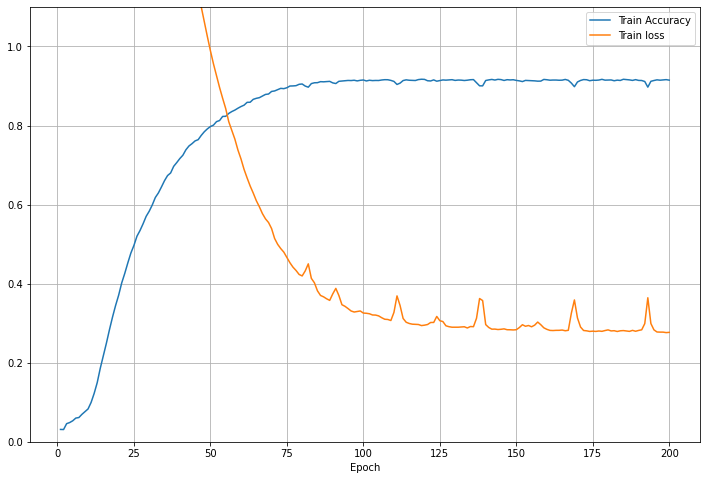

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='Train Accuracy')
plt.plot(xs, y_loss, label='Train loss')
plt.legend(), plt.grid(), 
plt.ylim(0,1.1)
plt.xlabel('Epoch')
plt.show()